<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=146124731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = True
cboe_years = [2019,2020,2021,2022]
load_tradier = False

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.003,0.5),
    'lp':(0.002,''),
    'sc':(0.003,0.5),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs={
    'ov':'Cumulative Return'
}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 200


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_ov_Cumulative Return_230714_230921_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:
    files = []
    for cboe_year in cboe_years:
        files.append(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_pyvollib_spx_{cboe_year}_1dte_all.csv")
        
    dfs = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)[configs['ov']]

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-10-11 12:15:40,204] A new study created in RDB with name: DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_cboe_ov_Cumulative Return_190102_220725_spx_st_0_simuledge_0
[I 2023-10-11 12:15:52,425] Trial 0 finished with value: -28.572 and parameters: {'sp': 0.18944575699260663, 'lp': 0.17445252383873178, 'sc': 0.11683396725824771, 'lc': 0.0889383200116022}. Best is trial 0 with value: -28.572.


Dropping 3 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:16:01,573] Trial 1 finished with value: -30.703 and parameters: {'sp': 0.2073789689453707, 'lp': 0.16789991004896837, 'sc': 0.27267202474692187, 'lc': 0.2253970879617313}. Best is trial 0 with value: -28.572.


Dropping 4 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:16:10,417] Trial 2 finished with value: -9.654 and parameters: {'sp': 0.19061360555440354, 'lp': 0.018211009065879066, 'sc': 0.45264368826218476, 'lc': 0.23379956136775668}. Best is trial 2 with value: -9.654.
[I 2023-10-11 12:16:19,384] Trial 3 finished with value: 2.76 and parameters: {'sp': 0.1676393250803487, 'lp': 0.03796687471619266, 'sc': 0.1344445444930234, 'lc': 0.04044601052022339}. Best is trial 3 with value: 2.76.
[I 2023-10-11 12:16:28,151] Trial 4 finished with value: 8.521 and parameters: {'sp': 0.3319926364957318, 'lp': 0.2479767143832097, 'sc': 0.012994782692625183, 'lc': 0.00951993995089746}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:16:36,971] Trial 5 finished with value: -18.986 and parameters: {'sp': 0.11116634895634207, 'lp': 0.09458911371755353, 'sc': 0.16732246321705352, 'lc': 0.06079731460334879}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:16:45,851] Trial 6 finished with value: -16.035 and parameters: {'sp': 0.23033550744046

Dropping 2 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:17:03,935] Trial 8 finished with value: -12.721 and parameters: {'sp': 0.053922202928170335, 'lp': 0.032368869840410396, 'sc': 0.40526467065378474, 'lc': 0.0065172106591940785}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:17:15,080] Trial 9 finished with value: 5.719 and parameters: {'sp': 0.25084101442432805, 'lp': 0.1373085530511374, 'sc': 0.0426814244843874, 'lc': 0.03048837130524218}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:17:26,556] Trial 10 finished with value: -15.837 and parameters: {'sp': 0.4445968462106292, 'lp': 0.3356955013055427, 'sc': 0.34433796169628955, 'lc': 0.3365531655730525}. Best is trial 4 with value: 8.521.


Dropping 9 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:17:35,706] Trial 11 finished with value: -131.248 and parameters: {'sp': 0.355174442436496, 'lp': 0.2750448128244686, 'sc': 0.042410549563057925, 'lc': 0.004717391998117437}. Best is trial 4 with value: 8.521.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:17:44,530] Trial 12 finished with value: -8.025 and parameters: {'sp': 0.32996899742886204, 'lp': 0.21983030908242418, 'sc': 0.007411443953986213, 'lc': 0.002570657504698457}. Best is trial 4 with value: 8.521.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:17:53,455] Trial 13 finished with value: 8.255 and parameters: {'sp': 0.3220862675002163, 'lp': 0.22675240767501417, 'sc': 0.04964261471006434, 'lc': 0.016900887797266832}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:18:02,131] Trial 14 finished with value: -22.06 and parameters: {'sp': 0.33859536035566856, 'lp': 0.2484927810781279, 'sc': 0.2051974529050479, 'lc': 0.050606499045529316}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:18:11,130] Trial 15 finished with value: 5.028 and parameters: {'sp': 0.47607597261166046, 'lp': 0.4690831468062697, 'sc': 0.06837839168961579, 'lc': 0.016015396984780737}. Best is trial 4 with value: 8.521.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:18:20,155] Trial 16 finished with value: -6.974 and parameters: {'sp': 0.4041235455491133, 'lp': 0.305635229676701, 'sc': 0.00859922

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:18:29,196] Trial 17 finished with value: -49.291 and parameters: {'sp': 0.30403423868147755, 'lp': 0.21201827495415435, 'sc': 0.30324723412921906, 'lc': 0.14836462182986943}. Best is trial 4 with value: 8.521.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:18:38,304] Trial 18 finished with value: 0.75 and parameters: {'sp': 0.3881413786689948, 'lp': 0.3636657027876461, 'sc': 0.08178654822100223, 'lc': 0.01891122209164075}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:18:47,895] Trial 19 finished with value: -32.212 and parameters: {'sp': 0.29041672780711786, 'lp': 0.20754227652228177, 'sc': 0.1745135701007806, 'lc': 0.06533763131842518}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:18:56,781] Trial 20 finished with value: 4.688 and parameters: {'sp': 0.2749637675906614, 'lp': 0.13175389597118503, 'sc': 0.48707003835043244, 'lc': 0.47706960535403364}. Best is trial 4 with value: 8.521.
[I 2023-10-11 12:19:05,557] Trial 21 finished with value: 0.941 and parameters: {'sp': 0.2576598189739454, 'lp': 0.14881647704840079, 'sc': 0.05513707378851808, 'lc': 0.014212972561266713}. Best is trial 4 with value: 8.521.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:19:14,421] Trial 22 finished with value: 11.46 and parameters: {'sp': 0.380253230179542, 'lp': 0.25485647651647086, 'sc': 0.009847603978812495, 'lc': 0.009312216936299557}. Best is trial 22 with value: 11.46.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:19:23,544] Trial 23 finished with value: 5.529 and parameters: {'sp': 0.4093718087269184, 'lp': 0.26558747851989256, 'sc': 0.0069780904893907425, 'lc': 0.0038733655612244846}. Best is trial 22 with value: 11.46.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:19:32,734] Trial 24 finished with value: 7.206 and parameters: {'sp': 0.3684827300931024, 'lp': 0.24046093403840305, 'sc': 0.09455949182418671, 'lc': 0.02834832560806687}. Best is trial 22 with value: 11.46.
[I 2023-10-11 12:19:41,751] Trial 25 finished with value: -10.213 and parameters: {'sp': 0.4934825462322683, 'lp': 0.38749498389018455, 'sc': 0.1525593376704214, 'lc': 0.032713076394103556}. Best is trial 22 with value: 11.46.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:19:50,754] Trial 26 finished with value: -15.38 and parameters: {'sp': 0.43387541069530616, 'lp': 0.2993963778478552, 'sc': 0.0383914599073348, 'lc': 0.015009392989815823}. Best is trial 22 with value: 11.46.
[I 2023-10-11 12:19:59,461] Trial 27 finished with value: 2.428 and parameters: {'sp': 0.3047152180783449, 'lp': 0.1845444448785591, 'sc': 0.08599

Dropping 4 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:20:35,721] Trial 31 finished with value: 3.546 and parameters: {'sp': 0.3674328833029587, 'lp': 0.254704689770832, 'sc': 0.10575462329143209, 'lc': 0.02473155054487464}. Best is trial 22 with value: 11.46.
[I 2023-10-11 12:20:44,569] Trial 32 finished with value: -33.607 and parameters: {'sp': 0.4052608034323977, 'lp': 0.18843613443087737, 'sc': 0.09070112291902893, 'lc': 0.010722279818725502}. Best is trial 22 with value: 11.46.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:20:53,226] Trial 33 finished with value: 1.222 and parameters: {'sp': 0.355713993005245, 'lp': 0.23299748370922685, 'sc': 0.032516579630662124, 'lc': 0.013140120556594267}. Best is trial 22 with value: 11.46.
[I 2023-10-11 12:21:01,968] Trial 34 finished with value: 3.452 and parameters: {'sp': 0.31600462017704584, 'lp': 0.19671878309471064, 'sc': 0.0752

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:21:10,509] Trial 35 finished with value: -15.098 and parameters: {'sp': 0.4391318115982211, 'lp': 0.27971529147539886, 'sc': 0.1304910239208244, 'lc': 0.03034970189585665}. Best is trial 22 with value: 11.46.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:21:19,468] Trial 36 finished with value: -8.278 and parameters: {'sp': 0.18772841810328225, 'lp': 0.1705771142534066, 'sc': 0.053929682045813304, 'lc': 0.0091973993468767}. Best is trial 22 with value: 11.46.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:21:28,169] Trial 37 finished with value: -32.085 and parameters: {'sp': 0.22314108317432566, 'lp': 0.18990063203347618, 'sc': 0.26351108608264295, 'lc': 0.07550733140927854}. Best

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:22:30,773] Trial 44 finished with value: -100.908 and parameters: {'sp': 0.20819072105636038, 'lp': 0.09141556900147021, 'sc': 0.36594983304297324, 'lc': 0.11851763678897893}. Best is trial 22 with value: 11.46.
[I 2023-10-11 12:22:39,685] Trial 45 finished with value: 14.948 and parameters: {'sp': 0.32270080490525077, 'lp': 0.11681419153103298, 'sc': 0.06658954749426861, 'lc': 0.018171879939617126}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:22:49,027] Trial 46 finished with value: 11.374 and parameters: {'sp': 0.31964715875913463, 'lp': 0.06840311536428789, 'sc': 0.06736991424207894, 'lc': 0.017881949750873965}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:22:57,978] Trial 47 finished with value: 1.321 and parameters: {'sp': 0.3260939070481193, 'lp': 0.04564307863586913, 'sc': 0.02566334299890631, 'lc': 0.022129529417280615}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:23:06,968] Trial 48 finished with value: 12.652 and parameters: {'sp': 0.38426016921574935, 'lp': 0.0811962178651023, 'sc': 0.07056222545961018, 'lc': 0.01826717078010363}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:23:15,909] Trial 49 finished with value: 10.677 and parameters: {'sp': 0.39161542545234285, 'lp': 0.0707787051133417, 'sc': 0.06467152389106792, 'lc': 0.01862058431585751}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:23:24,794] Trial 50 finished with value: 10.467 and parameters: {'sp': 0.42708101749325095, 'lp': 0.06996376971530964, 'sc': 0.06767385030768212, 'lc': 0.018719062402693543}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:23:33,681] Trial 51 finished with value: 10.543 and parameters: {'sp': 0.42292190393881623, 'lp': 0.06585824981115768, 'sc': 0.06653994816601594, 'lc': 0.019012109129996773}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:23:42,524] Trial 52 finished with value: 13.948 and parameters: {'sp': 0.38158225179544125, 'lp': 0.11203154247454236, 'sc': 0.11238811523437717, 'lc': 0.025266184580824108}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:23:51,953] Trial 53 finished with value: 8.56 and parameters: {'sp': 0.3910823813427061, 'lp': 0.1075192464892506, 'sc': 0.1226888673917145, 'lc': 0.04404975461754143}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:24:01,117] Trial 54 finished with value: 9.568 and parameters: {'sp': 0.45565489764684475, 'lp': 0.04134210443151409, 'sc': 0.10390725766872919, 'lc': 0.02608785758984537}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:24:10,318] Trial 55 finished with value: -15.41 and parameters: {'sp': 0.3478350647128126, 'lp': 0.08409225125780168, 'sc': 0.2998252548124393, 'lc': 0.07356954324721796}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:24:19,044] Trial 56 finished with value: 7.413 and parameters: {'sp': 0.3860667902675214, 'lp': 0.05310371232393717, 'sc': 0.14575054288803066, 'lc': 0.03313336103797108}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:24:28,014] Trial 57 finished with value: -1.665 and parameters: {'sp': 0.4088069652334313, 'lp': 0.10670620105560519, 'sc': 0.17092694207280135, 'lc': 0.05878610946023848}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:24:37,016] Trial 58 finished with value: 10.968 and parameters: {'sp': 0.3703849891968501, 'lp': 0.026556673541437786, 'sc': 0.07210760255072209, 'lc': 0.013520219211857438}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:24:46,164] Trial 59 finished with value: 8.172 and parameters: {'sp': 0.366

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:25:58,929] Trial 67 finished with value: 11.308 and parameters: {'sp': 0.4170129678296108, 'lp': 0.15384446643573169, 'sc': 0.09361517159635038, 'lc': 0.023347766031009107}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:26:08,203] Trial 68 finished with value: -7.435 and parameters: {'sp': 0.4751899391656756, 'lp': 0.12939664723397767, 'sc': 0.42515914016371525, 'lc': 0.2616959299310937}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:26:17,276] Trial 69 finished with value: 5.566 and parameters: {'sp': 0.399231960335769, 'lp': 0.09548681878235626, 'sc': 0.15473685428904116, 'lc': 0.037960249941835604}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:26:25,931] Trial 70 finished with value: -7.097 and parameters: {'sp': 0.3776888951843361, 'lp': 0.16122376294252544, 'sc': 0.19053155268769756, 'lc': 0.05113247814531656}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:26:35,093] Trial 71 finished with value: 10.304 and parameters: {'sp': 0.338214030303678, 'lp': 0.07894386414806209, 'sc': 0.05362317068917106, 'lc': 0.02050268227780506}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:26:44,375] Trial 72 finished with value: 4.74 and parameters: {'sp': 0.29151930789407965, 'lp': 0.13859688091074415, 'sc': 0.07726574187147717, 'lc': 0.015948639048786486}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:26:53,617] Trial 73 finished with value: 11.705 and parameters: {'sp': 0.36252132603861337, 'lp': 0.09778391145142011, 'sc': 0.13426846480881233, 'lc': 0.030107122460729985}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:27:03,185] Trial 74 finished with value: 10.428 and parameters: {'sp': 0.4523596892709557, 'lp': 0.11352596160025, 'sc': 0.13803599302448238, 'lc': 0.028426468340622835}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:27:12,148] Trial 75 finished with value: -7.171 and parameters: {'sp': 0.3616855363357854, 'lp': 0.09324244359960135, 'sc': 0.11144355099171385, 'lc': 0.005451017980944904}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:27:21,677] Trial 76 finished with value: 11.846 and parameters: {'sp': 0.4

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:27:33,234] Trial 77 finished with value: 11.991 and parameters: {'sp': 0.43977427619966575, 'lp': 0.1389852283892062, 'sc': 0.0985538051260877, 'lc': 0.03487047845143959}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:27:47,258] Trial 78 finished with value: 1.474 and parameters: {'sp': 0.46968384240644306, 'lp': 0.1442858709510252, 'sc': 0.08980640183536837, 'lc': 0.03575627199994069}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:27:57,193] Trial 79 finished with value: 14.501 and parameters: {'sp': 0.41877193383320815, 'lp': 0.17298359422409793, 'sc': 0.10053718948316223, 'lc': 0.024129704206498178}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:28:05,810] Trial 80 finished with value: -2.707 and parameters: {'sp': 0.43869212064750884, 'lp': 0.16848765160288037, 'sc': 0.16288359503708977, 'lc': 0.02704035412764126}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:28:14,996] Trial 81 finished with value: 8.012 and parameters: {'sp': 0.41625326520677003, 'lp': 0.13214874205264532, 'sc': 0.12112607528484806, 'lc': 0.023365836655297137}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:28:23,773] Trial 82 finished with value: 6.944 and parameters: {'sp': 0.48775611844221584, 'lp': 0.20018632507441012, 'sc': 0.0997736699767541, 'lc': 0.0421255154137258}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:28:33,043] Trial 83 finished with value: 12.666 and parameters: {'sp': 0.44221684518629567, 'lp': 0.17769017890495797, 'sc': 0.08262890739134973, 'lc': 0.025533127905556598}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:28:42,027] Trial 84 finished with value: 12.474 and parameters: {'sp': 0.4320462555387295, 'lp': 0.1829219381275909, 'sc': 0.07803693423525747, 'lc': 0.025929889305132257}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:28:50,800] Trial 85 finished with value: 14.046 and parameters: {'sp': 0.4272341685883852, 'lp': 0.18371277849253345, 'sc': 0.08273369294493434, 'lc': 0.024459030447992865}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:29:00,042] Trial 86 finished with value: 0.314 and parameters: {'sp': 0.46319901739355335, 'lp': 0.17991220551947068, 'sc': 0.044714496671787486, 'lc': 0.020229074540004353}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:29:09,030] Trial 87 finished with value: 4.228 and parameters: {'sp': 0.4975737154832449, 'lp': 0.2181793288794393, 'sc': 0.11562597159787627, 'lc': 0.025203129468157573}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:29:18,359] Trial 88 finished with value: 12.029 and parameters: {'sp': 0.42692471560991796, 'lp': 0.16136695002857224, 'sc': 0.08046504750434375, 'lc': 0.024385803484352726}. Best is trial 45 with value: 14.948.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:29:27,185] Trial 89 finished with value: -2.318 and parameters: {'sp': 0.4490295950958799, 'lp': 0.1615863701598105, 'sc': 0.05709400742974749, 'lc': 0.024606229374982108}. Best is trial 45 with value: 14.948.
[I 2023-10-11 12:29:36,192] Trial 90 finished with value: 16.274 and parameters: {'sp': 0.431371350785602, 'lp': 0.20814344306533364, 'sc': 0.08264803421868827, 'lc': 0.028580173935550696}. Best is trial 90 with value: 16.274.
[I 2023-10-11 12:29:45,146] Trial 91 finished with value: 15.264 and parameters: {'sp': 0.42503170176473953, 'lp': 0.17955402402851783, 'sc': 0.08292851116736967, 'lc': 0.02202570863477935}. Best is trial 90 with value: 16.274.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:29:54,490] Trial 92 finished with value: 15.961 and parameters: {'sp': 0.3986846731292126, 'lp': 0.20947096425811526, 'sc': 0.08289959856501822, 'lc': 0.028568759389791094}. Best is trial 90 with value: 16.274.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:30:03,362] Trial 93 finished with value: 5.487 and parameters: {'sp': 0.4035121035862283, 'lp': 0.20884850214283404, 'sc': 0.039977506270308646, 'lc': 0.026171434589247197}. Best is trial 90 with value: 16.274.
[I 2023-10-11 12:30:12,539] Trial 94 finished with value: 3.773 and parameters: {'sp': 0.39772169414370967, 'lp': 0.19474921025921096, 'sc': 0.12735957589854716, 'lc': 0.029283253371448752}. Best is trial 90 with value: 16.274.
[I 2023-10-11 12:30:21,909] Trial 95 finished with value: 12.416 and parameters: {'sp': 0.41653702736181275, 'lp': 0.17621667866018437, 'sc': 0.08516320852916497, 'lc': 0.021738053228108786}. Best is trial 90 with value: 16.274.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:30:30,800] Trial 96 finished with value: 20.167 and parameters: {'sp': 0.38616158587458327, 'lp': 0.20188658653444588, 'sc': 0.10521811925886859, 'lc': 0.03232931196559228}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:30:40,203] Trial 97 finished with value: 14.736 and parameters: {'sp': 0.4474534342942509, 'lp': 0.20179490159781163, 'sc': 0.10576668172060699, 'lc': 0.03165833455403164}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:30:49,271] Trial 98 finished with value: 4.582 and parameters: {'sp': 0.4590454720943248, 'lp': 0.22028380849419749, 'sc': 0.10983588882917703, 'lc': 0.03629412545049946}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:30:58,118] Trial 99 finished with value: 7.279 and parameters: {'sp': 0.48291266541718914, 'lp': 0.20056653944224884, 'sc': 0.13973792863978637, 'lc': 0.042344829991306614}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:31:07,445] Trial 100 finished with value: 9.039 and parameters: {'sp': 0.4137538202847375, 'lp': 0.2216715195549464, 'sc': 0.056464452082917796, 'lc': 0.028463447624970276}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:31:16,502] Trial 101 finished with value: 13.812 and parameters: {'sp': 0.4250764432949554, 'lp': 0.20358656384708, 'sc': 0.10638291341635936, 'lc': 0.03173378008740338}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:31:25,486] Trial 102 finished with value: 6.804 and parameters: {'sp': 0.4250749129468076, 'lp': 0.19105576226634982, 'sc': 0.1273565518004855, 'lc': 0.03973897272646336}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:31:34,777] Trial 103 finished with value: 9.113 and parameters: {'sp': 0.3967138814180896, 'lp': 0.21168001448041693, 'sc': 0.10654671107715141, 'lc': 0.03226649349566135}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:31:43,810] Trial 104 finished with value: 6.133 and parameters: {'sp': 0.4487918422633166, 'lp': 0.24211685411415984, 'sc': 0.09290699666877796, 'lc': 0.030402269844923696}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:31:53,259] Trial 105 finished with value: 3.871 and parameters: {'sp': 0.4069015207487683, 'lp': 0.206483139860071, 'sc': 0.06312557693079346, 'lc': 0.032158412342769185}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:32:02,291] Trial 106 finished with value: -11.67 and parameters: {'sp': 0.385878616911671, 'lp': 0.1881732028252558, 'sc': 0.18371372269287256, 'lc': 0.04690550680753586}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:32:11,778] Trial 107 finished with value: -5.538 and parameters: {'sp': 0.3762394138167238, 'lp': 0.22763683344839555, 'sc': 0.15229254966307001, 'lc': 0.04781622930975611}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:32:20,665] Trial 108 finished with value: -30.702 and parameters: {'sp': 0.

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-10-11 12:33:04,962] Trial 113 finished with value: 4.858 and parameters: {'sp': 0.11317929917545289, 'lp': 0.11316761839506981, 'sc': 0.09253314329325504, 'lc': 0.02194696959976809}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:33:13,758] Trial 114 finished with value: 10.554 and parameters: {'sp': 0.4124506082673771, 'lp': 0.17066612092163258, 'sc': 0.12218058898212926, 'lc': 0.03712868317055923}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:33:22,583] Trial 115 finished with value: -38.755 and parameters: {'sp': 0.3981436747461741, 'lp': 0.18494948522966406, 'sc': 0.4957852656713747, 'lc': 0.0829773483224521}. Best is trial 96 with va

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:33:49,026] Trial 118 finished with value: 6.355 and parameters: {'sp': 0.46412267378092253, 'lp': 0.4272264197653066, 'sc': 0.0880906852201439, 'lc': 0.023375957192447745}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:33:57,837] Trial 119 finished with value: 17.494 and parameters: {'sp': 0.4323647016226934, 'lp': 0.150268588252931, 'sc': 0.1011269530408035, 'lc': 0.021109336714203637}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:34:06,572] Trial 120 finished with value: -15.589 and parameters: {'sp': 0.4321623908213752, 'lp': 0.1485360269280388, 'sc': 0.35316744237283065, 'lc': 0.2063326234532851}. Best is trial 96 with value: 20.167.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:34:15,482] Trial 121 finished with value: -25.865 and parameters: {'sp': 0.4325358962859806, 'lp': 0.12552787891635453, 'sc': 0

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:35:00,789] Trial 126 finished with value: 5.222 and parameters: {'sp': 0.4840653319671842, 'lp': 0.158381025829791, 'sc': 0.13641455335610636, 'lc': 0.015007034820463526}. Best is trial 96 with value: 20.167.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:35:09,605] Trial 127 finished with value: -27.098 and parameters: {'sp': 0.47510746382645963, 'lp': 0.1359697767634226, 'sc': 0.04913669515880828, 'lc': 0.02920864877190899}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:35:18,671] Trial 128 finished with value: 10.075 and parameters: {'sp': 0.49208075704690424, 'lp': 0.1469070371357895, 'sc': 0.07182328949916728, 'lc': 0.02113209232487117}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:35:27,575] Trial 129 finished with value: 15.098 and parameters: {'sp': 0.4511418043084312, 'lp': 0.11868705628642291, 'sc': 0.10169225057903251, 'lc': 0.01937061731289002}. Best is trial 96 with value: 20.167.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-10-11 12:35:36,451] Trial 130 finished with value: -3.804 and parameters: {'sp': 0.45455089897886863, 'lp': 0.1197569113445871, 'sc': 0.018567041033951473, 'lc': 0.01775809456584309}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:35:45,612] Trial 131 finished with value: 10.043 and parameters: {'sp': 0.43936952933574674, 'lp': 0.16336685973179405, 'sc': 0.09696750522401046, 'lc': 0.02063161481648204}. Best is trial 96 with

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:35:54,344] Trial 132 finished with value: 12.807 and parameters: {'sp': 0.46757059997221073, 'lp': 0.13070455390084174, 'sc': 0.08618817961682398, 'lc': 0.011992799924263862}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:36:03,303] Trial 133 finished with value: 3.081 and parameters: {'sp': 0.44470179850970404, 'lp': 0.21330824992347808, 'sc': 0.10187736645019366, 'lc': 0.016555828917696774}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:36:12,115] Trial 134 finished with value: 11.271 and parameters: {'sp': 0.4778518169209231, 'lp': 0.143354428759209, 'sc': 0.12674426050755289, 'lc': 0.014975386823830521}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:36:21,163] Trial 135 finished with value: 11.299 and parameters: {'sp': 0.45883095156613735, 'lp': 0.1754728295656245, 'sc': 0.07684180942397682, 'lc': 0.019402392664879205}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:36:29,897] Trial 136 finished with value: -13.068 and parameters: {'sp': 0.4494157178430544, 'lp': 0.15128225818975846, 'sc': 0.1117036652888685, 'lc': 0.007244943525041377}. Best is trial 96 with value: 20.167.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:36:38,790] Trial 137 finished with value: -5.145 and parameters: {'sp': 0.40868637423031423, 'lp': 0.19421581059743936, 'sc': 0.06254482034442899, 'lc': 0.009760144100765977}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:36:47,571] Trial 138 finished with value: 10.522 and parameters: {'sp': 0.43445488616261946, 'lp': 0.18198892447874673, 'sc': 0.08807362616465651, 'lc': 0.026758793486675102}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:36:56,357] Trial 139 finished with value: -13.253 and parameters: {'sp': 0.46703293218012676, 'lp': 0.11950407871912352, 'sc': 0.036946478238816506, 'lc': 0.020977257063051827}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:37:05,310] Trial 140 finished with value: -4.335 and parameters: {'sp': 0.44546609493529876, 'lp': 0.15721483536773828, 'sc': 0.14283169754783728, 'lc': 0.01110899577628342}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:37:14,841] Trial 141 finished with value: 10.689 and parameters: {'sp': 0.42325566873414056, 'lp': 0.18569316436779332, 'sc': 0.07779539446832537, 'lc': 0.02385865922589841}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:37:23,848] Trial 142 finished with value: 13.167 and parameters: {'sp': 0.49818486682856444, 'lp': 0.1998084962042753, 'sc': 0.09686321091954495, 'lc': 0.027780701111810614}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:37:32,796] Trial 143 finished with value: 10.715 and parameters: {'sp': 0.4307850908305711, 'lp': 0.1653184451104805, 'sc': 0.08121906014669521, 'lc': 0.019056794520467317}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:37:41,854] Trial 144 finished with value: 7.455 and parameters: {'sp': 0.4083339286458533, 'lp': 0.1739263351387495, 'sc': 0.1049142317471882, 'lc': 0.01727495024363231}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:37:50,900] Trial 145 finished with value: -39.897 and parameters: {'sp': 0.41614413619422524, 'lp': 0.21663006414967628, 'sc': 0.29384205708169486, 'lc': 0.10567316192806658}. Best is trial 96 with value: 20.167.


Dropping 2 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:37:59,962] Trial 146 finished with value: 7.971 and parameters: {'sp': 0.4522703854464142, 'lp': 0.1337904102176946, 'sc': 0.1163916027185426, 'lc': 0.013690846528248984}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:38:09,060] Trial 147 finished with value: 8.803 and parameters: {'sp': 0.4383835139005982, 'lp': 0.18044661019653335, 'sc': 0.07118742266203774, 'lc': 0.02465639039317351}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:38:18,015] Trial 148 finished with value: -0.161 and parameters: {'sp': 0.26831305502873215, 'lp': 0.15718924115964833, 'sc': 0.05485523146362664, 'lc': 0.03218520581094087}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:38:26,930] Trial 149 finished with value: 13.275 and parameters: {'sp': 0.4779063693128186, 'lp': 0.20647208716334747, 'sc': 0.08825738513275655, 'lc': 0.02190179923801651}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:38:35,872] Trial 150 finished with value: 14.653 and parameters: {'sp': 0.4613304302399982, 'lp': 0.10340105558967042, 'sc': 0.09971626675467225, 'lc': 0.019471214423813492}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:38:44,878] Trial 151 finished with value: 14.086 and parameters: {'sp': 0.4644280099638548, 'lp': 0.1419051920578449, 'sc': 0.10229477085122167, 'lc': 0.019470646452722135}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:38:53,847] Trial 152 finished with value: 13.789 and parameters: {'sp': 0.46183193835602165, 'lp': 0.09947587181084472, 'sc': 0.09898753559173011, 'lc': 0.019615208295812668}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:39:02,960] Trial 153 finished with value: 9.247 and parameters: {'sp': 0.4871109619985202, 'lp': 0.14245559077986833, 'sc': 0.12693032083946593, 'lc': 0.01659377399038397}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:39:12,060] Trial 154 finished with value: 13.196 and parameters: {'sp': 0.46928552190433426, 'lp': 0.1268212303815274, 'sc': 0.10774042274182308, 'lc': 0.01882781586419007}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:39:20,809] Trial 155 finished with value: 9.256 and parameters: {'sp': 0.4549870054272795, 'lp': 0.11325102142038404, 'sc': 0.11958617054883985, 'lc': 0.029045934737103773}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:39:30,115] Trial 156 finished with value: 13.868 and parameters: {'sp': 0.4445420509146358, 'lp': 0.10445146774654125, 'sc': 0.09451481321404467, 'lc': 0.022735096221553522}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:39:38,860] Trial 157 finished with value: 7.868 and parameters: {'sp': 0.43365188894590634, 'lp': 0.14044762185863577, 'sc': 0.1327444009833748, 'lc': 0.013421714884243926}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:39:47,756] Trial 158 finished with value: 11.613 and parameters: {'sp': 0.478917422027114, 'lp': 0.08612546873799516, 'sc': 0.11143715286027266, 'lc': 0.026155947877918282}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:39:56,519] Trial 159 finished with value: 13.539 and parameters: {'sp': 0.4611990346890743, 'lp': 0.1480513928518327, 'sc': 0.08309067973804544, 'lc': 0.020733348961956916}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:40:05,427] Trial 160 finished with value: 10.127 and parameters: {'sp': 0.4193836104864278, 'lp': 0.16468391932471338, 'sc': 0.06546287805633033, 'lc': 0.021757066708594487}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:40:14,447] Trial 161 finished with value: 7.134 and parameters: {'sp': 0.4271234973629985, 'lp': 0.1880146091779907, 'sc': 0.08802569456515344, 'lc': 0.024559622498182946}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:40:23,641] Trial 162 finished with value: 8.632 and parameters: {'sp': 0.40507896149988853, 'lp': 0.16661728892986793, 'sc': 0.07416914404487138, 'lc': 0.020102619388886373}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:40:32,619] Trial 163 finished with value: 13.821 and parameters: {'sp': 0.44270227829925485, 'lp': 0.12055441656992832, 'sc': 0.10054346913000257, 'lc': 0.016006871681805247}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:40:41,648] Trial 164 finished with value: 14.584 and parameters: {'sp': 0.4270358779264345, 'lp': 0.15712925481651782, 'sc': 0.08205117505514865, 'lc': 0.022981862794893917}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:40:50,549] Trial 165 finished with value: -1.105 and parameters: {'sp': 0.4495134203022531, 'lp': 0.22955853782614288, 'sc': 0.09654578289441575, 'lc': 0.018045769854241757}. Best is trial 96 with value: 20.167.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:40:59,626] Trial 166 finished with value: -9.595 and parameters: {'sp': 0.4719259029049939, 'lp': 0.13432795880150528, 'sc': 0.059386537046685214, 'lc': 0.02958137011872861}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:41:08,688] Trial 167 finished with value: 0.428 and parameters: {'sp': 0.4189613940184458, 'lp': 0.15855341161963568, 'sc': 0.45951221660798325, 'lc': 0.4214915009998682}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:41:17,712] Trial 168 finished with value: 10.755 and parameters: {'sp': 0.43397223643252564, 'lp': 0.152746385938099, 'sc':

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:41:26,481] Trial 169 finished with value: 10.872 and parameters: {'sp': 0.4561252808446938, 'lp': 0.17649005893346878, 'sc': 0.08749781929631383, 'lc': 0.022775827547482978}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:41:35,422] Trial 170 finished with value: -7.184 and parameters: {'sp': 0.408995078859586, 'lp': 0.1459313762419161, 'sc': 0.2512972871915634, 'lc': 0.0044971620475488736}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:41:44,674] Trial 171 finished with value: 11.78 and parameters: {'sp': 0.4257012190115447, 'lp': 0.19618809304614188, 'sc': 0.07616701404465223, 'lc': 0.025737835430757014}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:41:53,808] Trial 172 finished with value: 11.902 and parameters: {'sp': 0.43990053850110206, 'lp': 0.16823995928827323, 'sc': 0.08433573074211051, 'lc': 0.024038184318043415}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:42:03,489] Trial 173 finished with value: 5.821 and parameters: {'sp': 0.4282303642840337, 'lp': 0.2040933385318459, 'sc': 0.10244598178503303, 'lc': 0.01969881914915394}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:42:12,277] Trial 174 finished with value: 0.787 and parameters: {'sp': 0.3897115163126295, 'lp': 0.18197902673149272, 'sc': 0.11867046382148318, 'lc': 0.01630745121521918}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:42:21,114] Trial 175 finished with value: 12.189 and parameters: {'sp': 0.4020115153288302, 'lp': 0.15828261735663476, 'sc': 0.09034117503246662, 'lc': 0.023508849535342675}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:42:29,907] Trial 176 finished with value: 6.617 and parameters: {'sp': 0.41692450302923323, 'lp': 0.18905148878566128, 'sc': 0.07066019818772533, 'lc': 0.02148356792366068}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:42:39,142] Trial 177 finished with value: 11.378 and parameters: {'sp': 0.449170068623131, 'lp': 0.1257470632471857, 'sc': 0.07958689666691575, 'lc': 0.018640852592090702}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:42:48,348] Trial 178 finished with value: 15.847 and parameters: {'sp': 0.464398590090564, 'lp': 0.17305449600094286, 'sc': 0.10261288133801044, 'lc': 0.027244242512382777}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:42:57,663] Trial 179 finished with value: -389.168 and parameters: {'sp': 0.4897333204629996, 'lp': 0.1337943370569723, 'sc': 0.10283853328919941, 'lc': 0.030435189590082193}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:43:06,476] Trial 180 finished with value: 10.191 and parameters: {'sp': 0.4670852508232154, 'lp': 0.17191357891465578, 'sc': 0.11609231931081904, 'lc': 0.026503789681435085}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:43:15,207] Trial 181 finished with value: 12.232 and parameters: {'sp': 0.4595421799116367, 'lp': 0.15169433893442988, 'sc': 0.09988163060598593, 'lc': 0.025246058399716546}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:43:24,045] Trial 182 finished with value: 6.048 and parameters: {'sp': 0.44090702089038725, 'lp': 0.21412353947323184, 'sc': 0.0876598680215878, 'lc': 0.02198553284701366}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:43:32,770] Trial 183 finished with value: 13.178 and parameters: {'sp': 0.43358921150585256, 'lp': 0.17795240222783903, 'sc': 0.10892965474151595, 'lc': 0.034785444773227966}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:43:41,683] Trial 184 finished with value: 11.405 and parameters: {'sp': 0.48059058003628924, 'lp': 0.19277969110722395, 'sc': 0.09492430908791588, 'lc': 0.027111941565323382}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:43:50,913] Trial 185 finished with value: 8.822 and parameters: {'sp': 0.4508544799308835, 'lp': 0.1627975005735795, 'sc': 0.06704334737837511, 'lc': 0.02271327905209708}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:43:59,670] Trial 186 finished with value: 11.795 and parameters: {'sp': 0.42503982794653483, 'lp': 0.14120255071353563, 'sc': 0.07925597053530117, 'lc': 0.02041147070818625}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:44:08,501] Trial 187 finished with value: 10.225 and parameters: {'sp': 0.46815937313554695, 'lp': 0.17283232579155497, 'sc': 0.12046939372052413, 'lc': 0.029453758952990527}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:44:17,549] Trial 188 finished with value: 9.111 and parameters: {'sp': 0.41399986011806406, 'lp': 0.19803057835046733, 'sc': 0.0946086849678658, 'lc': 0.024495896472083407}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:44:26,444] Trial 189 finished with value: 1.227 and parameters: {'sp': 0.44214617386165656, 'lp': 0.14970111215275, 'sc': 0.04790499772344878, 'lc': 0.029803320655121417}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:44:35,280] Trial 190 finished with value: 7.843 and parameters: {'sp': 0.4595506983247976, 'lp': 0.18399464748703043, 'sc': 0.10666771521918611, 'lc': 0.017299084153919425}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:44:44,284] Trial 191 finished with value: 14.225 and parameters: {'sp': 0.4198802304891526, 'lp': 0.1686703269359575, 'sc': 0.09392873847908005, 'lc': 0.022849767275504883}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:44:53,206] Trial 192 finished with value: 12.963 and parameters: {'sp': 0.42381205305593095, 'lp': 0.1604691341203722, 'sc': 0.07980550494108389, 'lc': 0.020691126180812584}. Best is trial 96 with value: 20.167.


Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.


[I 2023-10-11 12:45:01,930] Trial 193 finished with value: 13.76 and parameters: {'sp': 0.40243960457795486, 'lp': 0.16905183422086578, 'sc': 0.09367377049815191, 'lc': 0.02756690477992592}. Best is trial 96 with value: 20.167.
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-10-11 12:45:10,818] Trial 194 finished with value: 5.24 and parameters: {'sp': 0.4332971917646867, 'lp': 0.2074636781376458, 'sc': 0.06028659503458529, 'lc': 0.03778209904288221}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:45:19,965] Trial 195 finished with value: 5.99 and parameters: {'sp': 0.412487319785808, 'lp': 0.15336643585037502, 'sc': 0.10997015578764784, 'lc': 0.01511498999247669}. Best is trial 96 with value: 20.167.
[I 2023-10-11 12:45:29,089] Trial 196 finished with value: -4.625 and parameters: {'sp': 0.4500228823331706, 'lp': 0.3302868404882533, 'sc': 0.125

Dropping 3 trades. They are listed in the df_trades_implausible dataframe of the strategy object.
Best Score:  20.167
Best Params: 
  lc: 0.03232931196559228
  lp: 0.20188658653444588
  sc: 0.10521811925886859
  sp: 0.38616158587458327


# Backtest with current best score

Dropping 1 trades. They are listed in the df_trades_implausible dataframe of the strategy object.
*****  BACKTEST RESULTS  ****
Cumulative Return                                20.167
Max Drawdown                                    -32.899
Mean Net Max Loss                              2002.205
Max Net Max Loss                                 8570.0
Mean Return on Max Risk                           0.018
Std Dev of Return on Max Risk                     0.487
Risk Adj Cumulative Return On Scaled Max Risk    41.411
Trading Days                                        585
Wins                                                423
Losses                                              162
Breakeven                                             0
Win/Loss Ratio                                   72.308
Mean Win                                        596.727
Mean Loss                                     -1526.084
Mean Net Trans                                    7.865
Std Dev of Net Trans            

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2019-01-03,2019-01-04,4.0,2430.0,2505.0,2525.0,2405.0,0.386162,0.355186,1230.0,0.105218,0.083927,150.0,0.032329,0.029229,-45.0,0.201887,0.195875,-555.0,780.0,2000.0,0.00,2531.7200,6.0,2000.00,-1226.00,48248.00,-1226.00,NaN,-0.024781,0.000093,2500.0,1720.0,-0.712791,0.985744
1,2019-01-04,2019-01-07,4.0,2520.0,2575.0,2595.0,2500.0,0.386162,0.364955,860.0,0.105218,0.091002,127.5,0.032329,0.025190,-30.0,0.201887,0.191298,-380.0,577.5,0.0,0.00,2549.2600,6.0,0.00,571.50,48819.50,-654.50,0.011845,-0.013229,0.000094,2000.0,1422.5,0.401757,1.008035
2,2019-01-08,2019-01-09,4.0,2565.0,2615.0,2635.0,2540.0,0.386162,0.385055,860.0,0.105218,0.093547,130.0,0.032329,0.026663,-30.0,0.201887,0.169116,-320.0,640.0,0.0,0.00,2584.8301,6.0,0.00,634.00,49453.50,-20.50,0.012987,-0.000414,0.000095,2500.0,1860.0,0.340860,1.006817
3,2019-01-10,2019-01-11,4.0,2590.0,2630.0,2645.0,2570.0,0.386162,0.382088,565.0,0.105218,0.082146,85.0,0.032329,0.027945,-30.0,0.201887,0.177066,-270.0,350.0,0.0,0.00,2595.6499,6.0,0.00,344.00,49797.50,323.50,0.006956,0.006539,0.000094,2000.0,1650.0,0.208485,1.004170
4,2019-01-11,2019-01-14,4.0,2585.0,2625.0,2640.0,2570.0,0.386162,0.328910,515.0,0.105218,0.097172,100.0,0.032329,0.030058,-30.0,0.201887,0.162166,-215.0,370.0,0.0,286.01,2582.1399,6.0,286.01,77.99,49875.49,401.49,0.001566,0.008115,0.000094,1500.0,1130.0,0.069018,1.001380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2022-07-18,2022-07-19,4.0,3815.0,3890.0,3920.0,3790.0,0.386162,0.369992,1190.0,0.105218,0.092730,190.0,0.032329,0.025926,-45.0,0.201887,0.193040,-507.5,827.5,3000.0,0.00,3934.5701,6.0,3000.00,-2178.50,55818.44,6344.44,-0.037562,0.128238,0.000090,3000.0,2172.5,-1.002762,0.979945
581,2022-07-19,2022-07-20,4.0,3915.0,3995.0,4020.0,3885.0,0.386162,0.352721,1250.0,0.105218,0.093635,190.0,0.032329,0.031088,-55.0,0.201887,0.188743,-582.5,802.5,0.0,0.00,3959.4099,6.0,0.00,796.50,56614.94,7140.94,0.014269,0.144337,0.000097,3000.0,2197.5,0.362457,1.007249
582,2022-07-20,2022-07-21,4.0,3945.0,4025.0,4060.0,3915.0,0.386162,0.382334,1315.0,0.105218,0.090116,195.0,0.032329,0.020782,-40.0,0.201887,0.191426,-547.5,922.5,0.0,0.00,3998.8501,6.0,0.00,916.50,57531.44,8057.44,0.016188,0.162862,0.000094,3500.0,2577.5,0.355577,1.007112
583,2022-07-21,2022-07-22,4.0,3985.0,4055.0,4080.0,3955.0,0.386162,0.371589,1087.5,0.105218,0.092526,177.5,0.032329,0.030071,-50.0,0.201887,0.181461,-462.5,752.5,0.0,2276.00,3962.2400,6.0,2276.00,-1529.50,56001.94,6527.94,-0.026585,0.131947,0.000094,3000.0,2247.5,-0.680534,0.986389


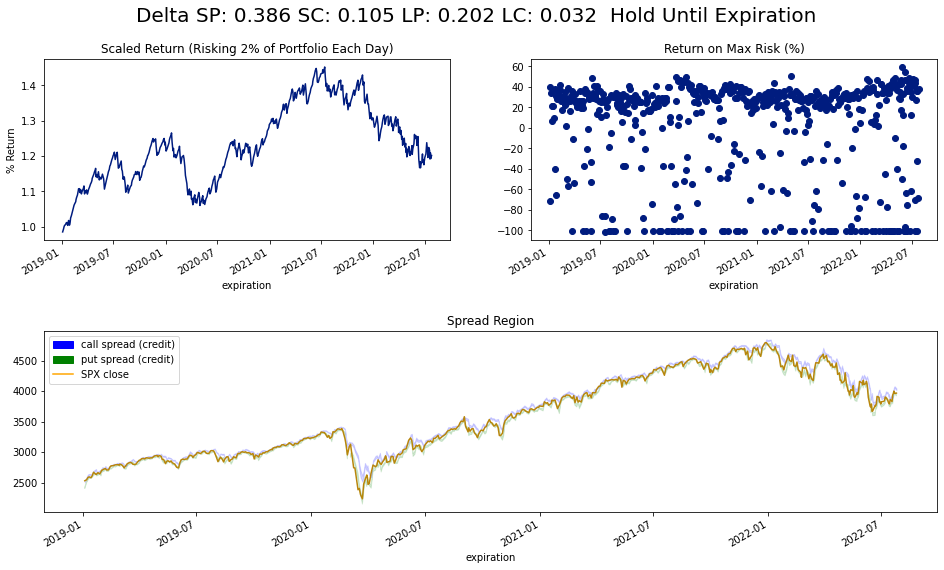

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2022-07-25,2022-07-26,0.386162,3950.0,0.345315,957.5,0.105218,4020.0,0.092432,165.0,0.032329,4045.0,0.025467,-40.0,0.201887,3930.0,0.197715,-472.5,4,610.0


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2022-07-25,2022-07-26,0.04,3885.0,0.03801,65.0,0.02,4050.0,0.019125,25.0,2,90.0
